In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [30]:
tasks = ['hospital_mortality', 'LOS_7', 'icu_admission', 'readmission_30']
metrics = ['auc', 'auprc', 'ace_abs_logistic_log']
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/notebooks/figures'


titles = {'hospital_mortality':'In-hospital Mortality', 'LOS_7':'Length of Stay > 7 days', 'icu_admission':'Admission to ICU', 'readmission_30':'Readmission after 30 days'}

In [31]:
y_axis = {
    'auc':{
        'lim':[0.75, 1.0],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[0.1, 0.75],
        'label':'AUPRC'
    },
    'ace_abs_logistic_log':{
        'lim':[-0.001, 0.045],
        'label':'Calibration'
    }
}

In [32]:
# Get baseline model
bl_df = pd.DataFrame()
for task in tasks:
    df = pd.read_csv(f'{results_path}/{task}/probes/baseline/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/eval.csv')
    df['task'] = task
    df['model'] = 'BL'
    bl_df = pd.concat([bl_df,df])

In [33]:
bl_df.query('phase == "test" and metric=="ace_abs_logistic_log"')

,phase,metric,CI_lower,CI_med,CI_upper,model,CLMBR,task
0,test,ace_abs_logistic_log,0.003241,0.003998,0.005476,BL,BL,hospital_mortality
0,test,ace_abs_logistic_log,0.028116,0.030949,0.035439,BL,BL,LOS_7
0,test,ace_abs_logistic_log,0.009621,0.011449,0.013532,BL,BL,icu_admission
0,test,ace_abs_logistic_log,0.031649,0.034534,0.037458,BL,BL,readmission_30


In [34]:
cl_grid = list(
    ParameterGrid(
        yaml.load(
            open(
                f"{os.path.join('/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/best','hyperparams')}.yml",
                'r'
            ),
            Loader=yaml.FullLoader
        )
    )
)

In [35]:
# Get best CL model by validation score for each task

cl_df = pd.DataFrame()
for i, hp in enumerate(cl_grid):
    for task in tasks:
#         df = pd.read_csv(f'{results_path}/{task}/probes/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_{hp["batch_size"]}_lr_{hp["lr"]}_temp_{hp["temp"]}_pool_rand_day/eval.csv')
        df = pd.read_csv(f'{results_path}/{task}/probes/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_3000_lr_5e-5_temp_0.01_pool_rand_day/eval.csv')
        df['task'] = task
        df['model'] = f'CL'
        cl_df = pd.concat([cl_df,df])

In [36]:
cl_df.query('phase=="test" and metric=="ace_abs_logistic_log"')

,phase,metric,CI_lower,CI_med,CI_upper,model,CLMBR,task
0,test,ace_abs_logistic_log,0.003703,0.005103,0.006874,CL,CL,hospital_mortality
0,test,ace_abs_logistic_log,0.025587,0.026633,0.028155,CL,CL,LOS_7
0,test,ace_abs_logistic_log,0.013871,0.015787,0.017766,CL,CL,icu_admission
0,test,ace_abs_logistic_log,0.023532,0.026503,0.029302,CL,CL,readmission_30


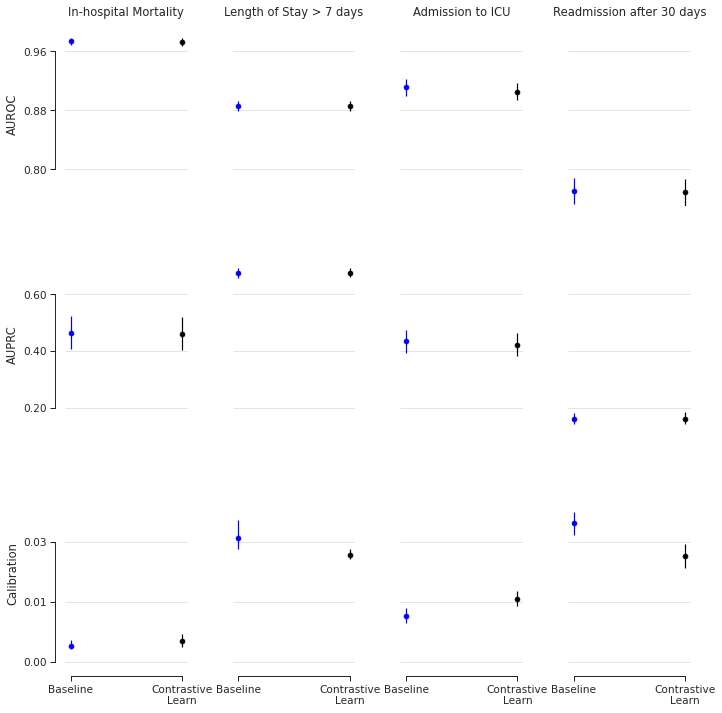

In [40]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=len(metrics), ncols=len(tasks), figsize=(10,12))
plt.tight_layout(w_pad=1,h_pad=2,rect=[0.05,0.15,1,0.95])

for r, metric in enumerate(metrics):
    for c, task in enumerate(tasks):
        bl_evals = bl_df.query('task==@task and metric==@metric and phase=="test"')
        cl_evals = cl_df.query('task==@task and metric==@metric and phase=="test"')
        
        bl_evals['CI_upper'] = (bl_evals['CI_upper'] - bl_evals['CI_med']).abs()
        bl_evals['CI_lower'] = (bl_evals['CI_med'] - bl_evals['CI_lower']).abs()
        
        cl_evals['CI_upper'] = (cl_evals['CI_upper'] - cl_evals['CI_med']).abs()
        cl_evals['CI_lower'] = (cl_evals['CI_med'] - cl_evals['CI_lower']).abs()
        
        axes[r][c].scatter(
            bl_evals['model'],
            bl_evals['CI_med'],
            color = 'blue'
        )
        
        axes[r][c].errorbar(
            bl_evals['model'],
            bl_evals['CI_med'],
            bl_evals[['CI_lower', 'CI_upper']].values.T,
            color='blue'
        )
        
        axes[r][c].scatter(
            cl_evals['model'],
            cl_evals['CI_med'],
            color = 'black'
        )
        
        axes[r][c].errorbar(
            cl_evals['model'],
            cl_evals['CI_med'],
            cl_evals[['CI_lower', 'CI_upper']].values.T,
            color = 'black'
        )
        
        
        axes[r][c].set_ylim(y_axis[metric]['lim'])
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r][c].grid(which='major', linewidth=0.5, axis='y')
        if r == 0:
            axes[r][c].set_title(titles[task])
        if r == len(metrics) - 1:
            axes[r][c].set_xlabel('')
            axes[r][c].set_xticklabels(labels=['Baseline', 'Contrastive\nLearn'])
        else:
            axes[r][c].set_xticklabels('')
            axes[r][c].set_xlabel('')
            axes[r][c].spines['bottom'].set_color('white')
            axes[r][c].tick_params(axis='x', length=0)  
        if c == 0:
            axes[r][c].set_ylabel(y_axis[metric]['label'])
            axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            axes[r][c].set_yticklabels('')
            axes[r][c].set_ylabel('')
            axes[r][c].spines['left'].set_color('white')
            axes[r][c].tick_params(axis='y', length=0)
sns.despine(offset=10, trim=True,)


plt.savefig('figures/base_task_eval.png', bbox_inches='tight')
plt.show()
